In [31]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative

In [32]:
# Khởi tạo danh sách giá trị ngưỡng
thresholds = []

In [33]:
# Đọc folder huấn luyện
folder_hl = 'TinHieuHuanLuyen'

In [34]:
def cal_ste(y,frame_size, hop_size):
    #tính STE bằng tổng bình phương giá trị của các samples
    return np.array([sum(abs(y[i:i + frame_size] ** 2)) for i in range(0, len(y) - frame_size, hop_size)])

In [35]:
def normalize(ste):
    #chuẩn hóa về dải 0-1
    return ste/max(ste)

In [36]:
# Tìm ngưỡng bằng file huấn luyện
def cal_threshold(ste):
        # Xác định ngưỡng bằng 10% trung bình của ste
        threshold = np.mean(ste) * 0.1
        return threshold



In [37]:
def threshold_avg():
    # Khởi tạo tập ngưỡng
    thresholds = []
    i = 1

    # Duyệt file_name trong list của folder huấn luyện
    for file_name in os.listdir(folder_hl):

        # Nếu file_name kết thúc bằng đuôi .wav >> file âm thanh
        if file_name.endswith('.wav'): 

            # Viết đường dẫn đầy đủ của tệp WAV
            file_path = os.path.join(folder_hl, file_name)

            # Đọc tệp WAV
            y, fs = librosa.load(file_path)

            # Số mẫu trong 1 khung: 256 (chia khung càng nhỏ để cho ra kết qủa cost function càng chuẩn)
            frame_size = 256

            # Dùng overlap để cải thiện độ chính xác
            hop_size = 128
            
            # Tính STE cho mỗi frame
            ste = cal_ste(y, frame_size, hop_size)

            # Chuẩn hóa STE
            ste_normalize= normalize(ste)

            # Tính ngưỡng của mỗi file
            threshold= cal_threshold(ste_normalize)

            # Thêm ngưỡng vào mảng các ngưỡng
            thresholds.append(threshold)

    # Tính ngưỡng trung bình bằng trung bình mảng ngưỡng
    threshold_avg = np.mean(thresholds)

    # Trả về ngưỡng trung bình
    return threshold_avg


In [38]:
#Tính cost function
def cost_function(file_name, y, fs, frame_size, hop_size, segments):
    # Khởi tạo segments chuẩn
        segments_true = []
        if file_name == "phone_F2.wav":
            segments_true.append((1.02 * fs / hop_size, 4.04 * fs / hop_size))
        if file_name == "phone_M2.wav":
            segments_true.append((0.53 * fs / hop_size, 2.52 * fs / hop_size))
        if file_name == "studio_F2.wav":
            segments_true.append((0.77 * fs / hop_size, 2.37 * fs / hop_size))
        if file_name == "studio_M2.wav":
            segments_true.append((0.45 * fs / hop_size, 1.93 * fs / hop_size))
        if file_name == "phone_F1.wav":
            segments_true.append((0.53 * fs / hop_size, 2.75 * fs / hop_size))
        if file_name == "phone_M1.wav":
            segments_true.append((0.46 * fs / hop_size, 3.52 * fs / hop_size))
        if file_name == "studio_F1.wav":
            segments_true.append((0.68 * fs / hop_size, 2.15 * fs / hop_size))
        if file_name == "studio_M1.wav":
            segments_true.append((0.87 * fs / hop_size, 2.06 * fs / hop_size))
            
        # Tính số frame
        number_of_frames = int(np.ceil((len(y) - frame_size + hop_size) / hop_size))

        # Khởi tạo nhãn slience(0) cho mỗi frame
        label = [0] * number_of_frames

        # Gắn nhãn speech(1) cho những frame nằm trong vùng từ start tới end
        for segment in segments:
            for i in range(segment[0], segment[1]+1):
                label[i] = 1

        # Làm tương tự với kết quả chuẩn
        label_true = [0] * number_of_frames

        for segment in segments_true:
            for i in range(int(segment[0]), int(segment[1]+1)):
                label_true[i] = 1

        # Lưu lại số kết quả sai lệch
        mistake = 0
        for i in range(number_of_frames):
            if label[i] != label_true[i]:
                mistake = mistake + 1
        return mistake
        

In [39]:
# Phân đoạn tín hiệu thành tiếng nói và khoảng lặng
def segment(threshold):
    cf = 0
    for file_name in os.listdir(folder_hl):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_hl, file_name)
            y, fs = librosa.load(file_path)
            frame_size = 256
            hop_size = 128

            # Tìm start và end và thêm nó vào mảng start và end
            segments = []
            starts = []
            ends = []
            start = None
            end = None
            ste = cal_ste(y, frame_size, hop_size)
            ste = normalize(ste)
            for i in range(len(ste)):
                if ste[i] > threshold:
                    if end is None:
                        start = i
                    end = i + 1
                else:
                    if start is not None:
                        starts.append(start)
                        ends.append(end)
                        start = None
                        end = None

            # Lọc khoảng lặng ảo dưới 0.3s
            i = 0
            while i < (len(ends) - 1):
                if (starts[i + 1] * hop_size / fs) - (ends[i] * hop_size / fs) <= 0.3:
                    starts.pop(i + 1)
                    ends.pop(i)
                else:
                    i = i + 1

            # Thêm start và end sau lọc vào segments kết quả
            for i in range(len(starts)):
                segments.append((starts[i], ends[i]))
            mistake= cost_function(file_name, y, fs, frame_size, hop_size, segments)

            # Tính cost_function bằng số frame nhầm lẫn
            cf += mistake

    # Trả về cost function cho thuật toán
    return cf
    

In [40]:
# Tối ưu hóa ngưỡng
def optimize_threshold(threshold, max_iterations, step):
    iteration = 0
    best_threshold = threshold
    new_threshold = threshold + step
    flag = 1
    while iteration < max_iterations:
            if (segment(new_threshold) <= segment(threshold)):
                best_threshold = new_threshold
                threshold= new_threshold
                if (flag):
                    new_threshold = threshold + step
                else:
                    new_threshold = threshold - step
            else: 
                if (flag):
                     flag = 0
                     new_threshold = threshold - step
                else:
                     flag = 1
                     new_threshold = threshold + step
            iteration += 1
    
    return best_threshold

In [41]:
threshold = threshold_avg()
best_threshold = optimize_threshold(threshold, 30, 0.0005)
print(best_threshold)
print(segment(best_threshold))

0.0029792745591389258
15


In [42]:
# Đọc file kiểm thử
folder_kt = 'TinHieuKiemThu'

In [43]:
#Vẽ biểu đồ
def draw():
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 4))
        librosa.display.waveshow(y, sr=fs, ax=ax[0], alpha=0.5)
        ax[0].set(title=file_name)
        ax[1].plot(np.arange(len(ste)) * hop_size / fs, ste, color='blue')
        ax[1].axhline(y=threshold, color='r', linestyle='--')
        ax[1].set(title='Short-term energy (STE)')
        for segment in segments:
            ax[1].axvspan(segment[0] * hop_size / fs, segment[1] * hop_size / fs, alpha=0.2, color='gray')
        plt.tight_layout()
        plt.show()


Kết quả dự đoán của  phone_F1.wav  :
           start =  0.5456689342403628 end =  2.7341496598639456
           Tỉ lệ phân đoạn đúng:  99.10394265232975 %


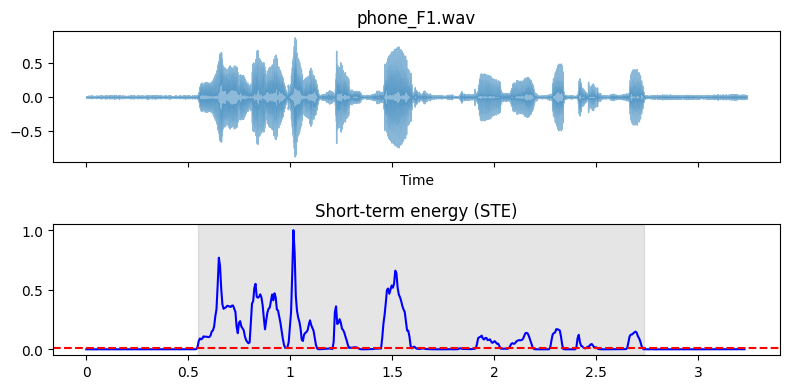

Kết quả dự đoán của  phone_M1.wav  :
           start =  0.46439909297052157 end =  3.517823129251701
           Tỉ lệ phân đoạn đúng:  99.86033519553072 %


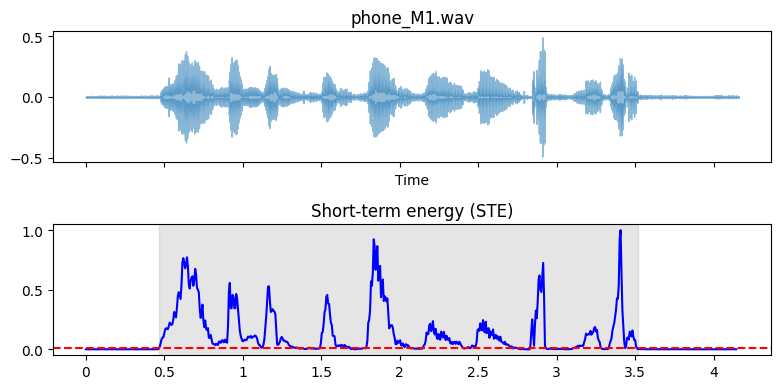

Kết quả dự đoán của  studio_F1.wav  :
           start =  0.6733786848072563 end =  2.147845804988662
           Tỉ lệ phân đoạn đúng:  99.7971602434077 %


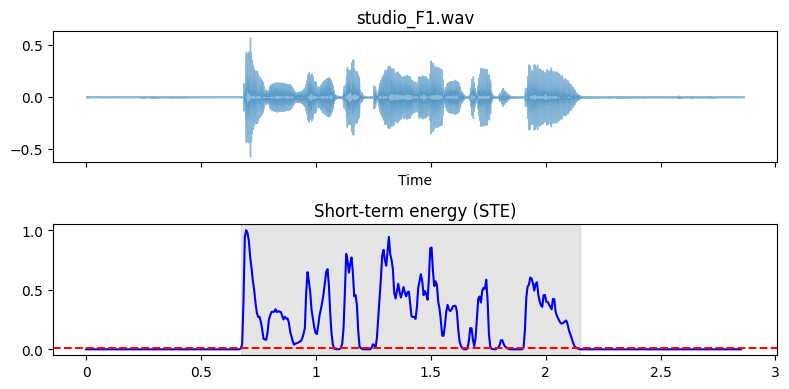

Kết quả dự đoán của  studio_M1.wav  :
           start =  0.9229931972789116 end =  2.049160997732426
           Tỉ lệ phân đoạn đúng:  97.65957446808511 %


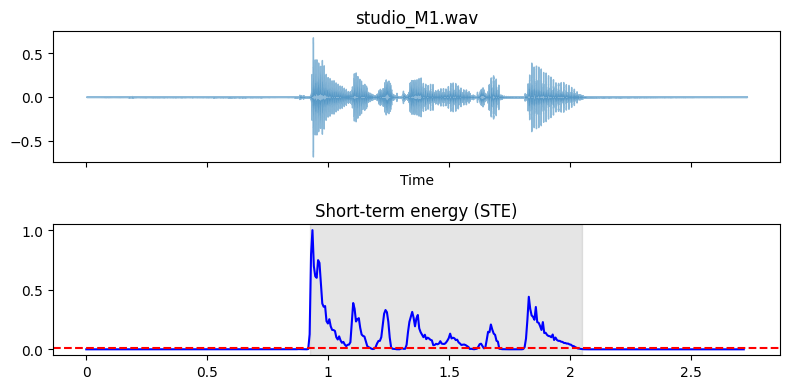

Tỉ lệ phân đoạn đúng tổng quát:  99.1953509164059 %


In [44]:
cost_func = 0
num_of_all_frames = 0
for file_name in os.listdir(folder_kt):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_kt, file_name)
            y, fs = librosa.load(file_path)
            frame_size = 256
            hop_size = 128
            number_of_frames = int(np.ceil((len(y) - frame_size + hop_size) / hop_size))
            segments = []
            starts = []
            ends = []
            start = None
            end = None
            ste = cal_ste(y, frame_size, hop_size)
            ste = normalize(ste)
            for i in range(len(ste)):
                if ste[i] > best_threshold:
                    if end is None:
                        start = i
                    end = i + 1
                else:
                    if start is not None:
                        starts.append(start)
                        ends.append(end)
                        start = None
                        end = None

                # Lọc khoảng lặng ảo dưới 0.3s
            i = 0
            while i < (len(ends) - 1):
                if (starts[i + 1] * hop_size / fs) - (ends[i] * hop_size / fs) <= 0.3:
                    starts.pop(i + 1)
                    ends.pop(i)
                else:
                    i = i + 1

            print("Kết quả dự đoán của ", file_name, " :")
            # Thêm start và end sau lọc vào segments kết quả
            for i in range(len(starts)):
                segments.append((starts[i], ends[i]))
                print("           start = ", starts[i] * hop_size / fs, "end = ", ends[i] * hop_size / fs)
            number_of_frames = int(np.ceil((len(y) - frame_size + hop_size) / hop_size))
            num_of_all_frames += number_of_frames
            mistake= cost_function(file_name, y, fs, frame_size, hop_size, segments)
            cost_func += mistake
            print("           Tỉ lệ phân đoạn đúng: ", 100-mistake/number_of_frames*100, "%")
            draw()
print("Tỉ lệ phân đoạn đúng tổng quát: ", 100-cost_func/num_of_all_frames*100, "%")